In [ ]:
import itk
import glob
import numpy as np
import matplotlib.pyplot as plt
import icon_registration as icon
import icon_registration.networks as networks
import torch
import random

In [56]:
3

3

In [2]:
roots = glob.glob("dxa2d_processed/dxa2d/*")

paths = [sorted(glob.glob(f"{root}/*.dcm")) for root in roots]

In [3]:
knees = []
for path in paths:
    for subpath in path:
        im = np.array(itk.imread(subpath))[0]
        if im.shape[1] == 640:
            knees.append(im)


In [4]:
flipped_knees = []

for im in knees[:84:2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    
for im in knees[85::2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[1:85:2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[86::2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    


In [5]:
big_enough_knees = []
for im in flipped_knees:
    if im.shape[0] >= 845:
        big_enough_knees.append(im[:845])
big_enough_knees = torch.tensor(np.array(big_enough_knees))[:, None, :, :] / 255.

test_imgs = big_enough_knees[-10:]
big_enough_knees = big_enough_knees[:-10]

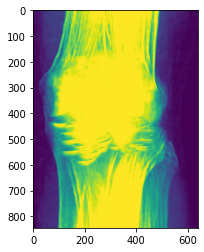

In [6]:
plt.imshow(torch.max(big_enough_knees, axis=0)[0][0])

In [24]:

BATCH_SIZE = 8
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
for _ in range(3):
    inner_net = icon.TwoStepRegistration(icon.DownsampleRegistration(inner_net, 2), icon.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = icon.GradientICON(
    inner_net,
    icon.LNCC(sigma=5),
    3
)
input_shape = big_enough_knees[:1].size()
netGrad.assign_identity_map(input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

0

In [25]:
def make_batch():
    idx = range(len(big_enough_knees))
    imgs_idx = [random.choice(idx) for _ in range(BATCH_SIZE)]

    imgs = [big_enough_knees[i:i+1] for i in imgs_idx]
    return torch.cat(imgs).cuda()
    

In [26]:
make_batch().shape

torch.Size([8, 1, 845, 640])

In [27]:
netGrad(make_batch(), make_batch())

ICONLoss(all_loss=tensor(1.9290, device='cuda:0', grad_fn=<AddBackward0>), inverse_consistency_loss=tensor(0., device='cuda:0', grad_fn=<AddBackward0>), similarity_loss=tensor(1.9290, device='cuda:0', grad_fn=<AddBackward0>), transform_magnitude=tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), flips=tensor(0.))

In [87]:
icon.train_batchfunction(netGrad, optimizerGrad, lambda : (make_batch(), make_batch()), steps=2000)

ICONLoss(all_loss=0.04788707569241524, inverse_consistency_loss=0.012414593249559402, similarity_loss=0.01064329594373703, transform_magnitude=0.0021371962502598763, flips=0.0)
ICONLoss(all_loss=0.04399140179157257, inverse_consistency_loss=0.010724086314439774, similarity_loss=0.01181914284825325, transform_magnitude=0.002786071738228202, flips=0.0)
ICONLoss(all_loss=0.047577641904354095, inverse_consistency_loss=0.012033889070153236, similarity_loss=0.011475970968604088, transform_magnitude=0.002056935103610158, flips=0.0)
ICONLoss(all_loss=0.053430818021297455, inverse_consistency_loss=0.012058250606060028, similarity_loss=0.01725606434047222, transform_magnitude=0.0018191937124356627, flips=0.0)
ICONLoss(all_loss=0.042245082557201385, inverse_consistency_loss=0.010066011920571327, similarity_loss=0.012047046795487404, transform_magnitude=0.0024665570817887783, flips=0.0)
ICONLoss(all_loss=0.051673758774995804, inverse_consistency_loss=0.011587679386138916, similarity_loss=0.0169107

ICONLoss(all_loss=0.023792613297700882, inverse_consistency_loss=0.0031231828033924103, similarity_loss=0.014423064887523651, transform_magnitude=0.0018940215231850743, flips=0.0)
ICONLoss(all_loss=0.024977542459964752, inverse_consistency_loss=0.0035170791670680046, similarity_loss=0.014426304027438164, transform_magnitude=0.0038734672125428915, flips=0.0)
ICONLoss(all_loss=0.02443603239953518, inverse_consistency_loss=0.0033872858621180058, similarity_loss=0.014274174347519875, transform_magnitude=0.003509493311867118, flips=0.0)
ICONLoss(all_loss=0.021777108311653137, inverse_consistency_loss=0.0027624471113085747, similarity_loss=0.013489766046404839, transform_magnitude=0.0016581184463575482, flips=0.0)
ICONLoss(all_loss=0.020649518817663193, inverse_consistency_loss=0.002886054804548621, similarity_loss=0.011991353705525398, transform_magnitude=0.001991791184991598, flips=0.0)
ICONLoss(all_loss=0.03551153093576431, inverse_consistency_loss=0.004723356571048498, similarity_loss=0.

ICONLoss(all_loss=0.02971748076379299, inverse_consistency_loss=0.004094875883311033, similarity_loss=0.01743285357952118, transform_magnitude=0.0029330006800591946, flips=0.0)
ICONLoss(all_loss=0.021977724507451057, inverse_consistency_loss=0.002644837833940983, similarity_loss=0.014043211005628109, transform_magnitude=0.0017360455822199583, flips=0.0)
ICONLoss(all_loss=0.0268569253385067, inverse_consistency_loss=0.0031583807431161404, similarity_loss=0.017381783574819565, transform_magnitude=0.0021304793190211058, flips=0.0)
ICONLoss(all_loss=0.020503386855125427, inverse_consistency_loss=0.0023369661066681147, similarity_loss=0.013492487370967865, transform_magnitude=0.0020686560310423374, flips=0.0)
ICONLoss(all_loss=0.02733243815600872, inverse_consistency_loss=0.0033227019011974335, similarity_loss=0.01736433245241642, transform_magnitude=0.003193202195689082, flips=0.0)
ICONLoss(all_loss=0.019674940034747124, inverse_consistency_loss=0.002995534799993038, similarity_loss=0.0106

ICONLoss(all_loss=0.02074735052883625, inverse_consistency_loss=0.0020600827410817146, similarity_loss=0.014567102305591106, transform_magnitude=0.0019365425687283278, flips=0.0)
ICONLoss(all_loss=0.02668142318725586, inverse_consistency_loss=0.0035005277022719383, similarity_loss=0.01617984101176262, transform_magnitude=0.0022630018647760153, flips=0.0)
ICONLoss(all_loss=0.020836496725678444, inverse_consistency_loss=0.002201175782829523, similarity_loss=0.014232968911528587, transform_magnitude=0.0014762284699827433, flips=0.0)
ICONLoss(all_loss=0.017129337415099144, inverse_consistency_loss=0.001845208229497075, similarity_loss=0.011593712493777275, transform_magnitude=0.001810144749470055, flips=0.0)
ICONLoss(all_loss=0.01737070269882679, inverse_consistency_loss=0.0020793015137314796, similarity_loss=0.011132798157632351, transform_magnitude=0.002993358764797449, flips=0.0)
ICONLoss(all_loss=0.017680855467915535, inverse_consistency_loss=0.0019180697854608297, similarity_loss=0.01

ICONLoss(all_loss=0.02488255500793457, inverse_consistency_loss=0.002084651729092002, similarity_loss=0.018628600984811783, transform_magnitude=0.002045043045654893, flips=0.0)
ICONLoss(all_loss=0.01974506303668022, inverse_consistency_loss=0.002000607782974839, similarity_loss=0.013743238523602486, transform_magnitude=0.0020916752982884645, flips=0.0)
ICONLoss(all_loss=0.019223058596253395, inverse_consistency_loss=0.0023041237145662308, similarity_loss=0.012310687452554703, transform_magnitude=0.004881981294602156, flips=0.0)
ICONLoss(all_loss=0.02746601030230522, inverse_consistency_loss=0.003554999828338623, similarity_loss=0.016801010817289352, transform_magnitude=0.0033527822233736515, flips=2.875)
ICONLoss(all_loss=0.02233169786632061, inverse_consistency_loss=0.002401871606707573, similarity_loss=0.015126083046197891, transform_magnitude=0.0024946853518486023, flips=0.0)
ICONLoss(all_loss=0.021259738132357597, inverse_consistency_loss=0.0019679833203554153, similarity_loss=0.01

In [118]:
netGrad.regis_net.load_state_dict(torch.load("results/cancel-1/network_weights_1800"))
netGrad.eval()

GradientICON(
  (regis_net): TwoStepRegistration(
    (netPhi): DownsampleRegistration(
      (net): TwoStepRegistration(
        (netPhi): DownsampleRegistration(
          (net): TwoStepRegistration(
            (netPhi): DownsampleRegistration(
              (net): FunctionFromVectorField(
                (net): UNet2(
                  (downConvs): ModuleList(
                    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                  )
                  (upConvs): ModuleList(
                    (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
               

In [101]:
image_A, image_B = test_imgs.cuda(), test_imgs.cuda().flip(dims=(0,))

In [107]:
with torch.no_grad():
    netGrad(image_A, image_B)

In [108]:
def show(im):
    plt.imshow(im.detach().cpu())
    plt.show()

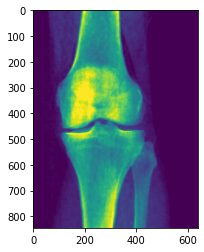

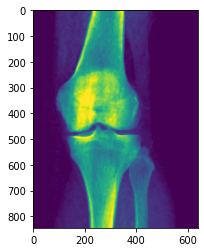

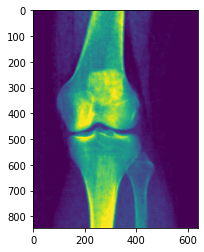

In [109]:
show(image_A[5, 0])
show(netGrad.warped_image_A[5, 0])
show(image_B[5, 0])

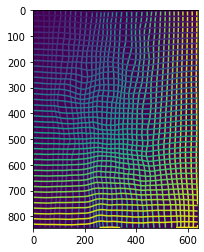

In [110]:
plt.contour(netGrad.phi_AB_vectorfield[5, 1].detach().cpu(), 40)
plt.contour(netGrad.phi_AB_vectorfield[5, 0].detach().cpu(), 40)
show(image_A[0, 0] * 0)

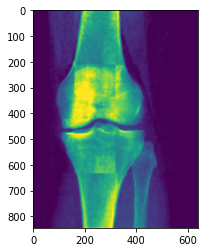

In [111]:
plt.imshow(itk.checker_board_image_filter(image_A[5, 0].cpu().numpy(), netGrad.warped_image_B[5, 0].cpu().numpy()))

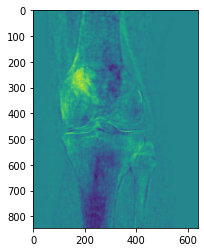

In [112]:
show((image_A[5, 0] - netGrad.warped_image_B[5, 0]))

In [120]:
netGrad.similarity = icon.ssd
netGrad.lmbda = .2

In [121]:
atlas = torch.nn.Parameter(torch.randn(1, 1, 845, 640, device="cuda"))
with torch.no_grad():
    atlas[:] = torch.mean(big_enough_knees, axis=0, keepdims=True)

atlas_exp = atlas.expand(BATCH_SIZE, -1, -1, -1).cuda()
params = [atlas]

In [122]:
optim = torch.optim.Adam(params, lr=.1)


In [123]:
for _ in range(273):
    image_A = make_batch()
    optim.zero_grad()
    loss_obj = netGrad(atlas_exp, image_A)
    disp_direction_loss = torch.mean(torch.mean(netGrad.phi_AB_vectorfield - netGrad.identity_map, axis=0)**2)
    print(disp_direction_loss)
    (loss_obj.all_loss + 3 * disp_direction_loss).backward()
    optim.step()
    print(icon.losses.to_floats(loss_obj))

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.02443474531173706, inverse_consistency_loss=0.012947766110301018, similarity_loss=0.021845191717147827, transform_magnitude=0.00366520369425416, flips=0.0)
tensor(9.0986e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.028850378468632698, inverse_consistency_loss=0.02298048511147499, similarity_loss=0.02425428107380867, transform_magnitude=0.002002299064770341, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.023493502289056778, inverse_consistency_loss=0.022748559713363647, similarity_loss=0.01894379034638405, transform_magnitude=0.0018734224140644073, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.017346184700727463, inverse_consistency_loss=0.012531698681414127, similarity_loss=0.014839845709502697, transform_magnitude=0.0010188550222665071, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009415453299880028, inverse_consistency_loss=0.00962160900235176, similarity_loss=0.007491131313145161, transform_magnitude=0.0038055081386119127, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011036914773285389, inverse_consistency_loss=0.00935734435915947, similarity_loss=0.009165446273982525, transform_magnitude=0.0016032606363296509, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010349433869123459, inverse_consistency_loss=0.007986253127455711, similarity_loss=0.008752183057367802, transform_magnitude=0.0015777829103171825, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009522806853055954, inverse_consistency_loss=0.007582793477922678, similarity_loss=0.008006248623132706, transform_magnitude=0.0009614788577891886, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
I

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.007944588549435139, inverse_consistency_loss=0.007381180301308632, similarity_loss=0.006468352861702442, transform_magnitude=0.0010231026681140065, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009148132055997849, inverse_consistency_loss=0.007712994702160358, similarity_loss=0.0076055326499044895, transform_magnitude=0.000839221989735961, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008291361853480339, inverse_consistency_loss=0.007852533832192421, similarity_loss=0.006720855366438627, transform_magnitude=0.0013551757438108325, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008967855013906956, inverse_consistency_loss=0.007509185466915369, similarity_loss=0.007466018199920654, transform_magnitude=0.0012151955161243677, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(6.4274e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008684000000357628, inverse_consistency_loss=0.008092701435089111, similarity_loss=0.007065459620207548, transform_magnitude=0.0008874836494214833, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009514701552689075, inverse_consistency_loss=0.00885158870369196, similarity_loss=0.0077443839982151985, transform_magnitude=0.0019486176315695047, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008813110180199146, inverse_consistency_loss=0.008368909358978271, similarity_loss=0.007139327935874462, transform_magnitude=0.0014120589476078749, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009821824729442596, inverse_consistency_loss=0.00780633557587862, similarity_loss=0.008260557428002357, transform_magnitude=0.0007603733683936298, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010677607730031013, inverse_consistency_loss=0.010495835915207863, similarity_loss=0.008578440174460411, transform_magnitude=0.0011413240572437644, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008913167752325535, inverse_consistency_loss=0.008332138881087303, similarity_loss=0.007246739696711302, transform_magnitude=0.0011597074335440993, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00882786326110363, inverse_consistency_loss=0.008115625008940697, similarity_loss=0.007204737979918718, transform_magnitude=0.0016446738736703992, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008183874189853668, inverse_consistency_loss=0.007644489873200655, similarity_loss=0.006654975935816765, transform_magnitude=0.0005107677425257862, flips=0.0)
tensor(8.6775e-05, device='cuda:0', grad_fn=<MeanBackward

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010211818851530552, inverse_consistency_loss=0.009088156744837761, similarity_loss=0.008394187316298485, transform_magnitude=0.0019141489174216986, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008644556626677513, inverse_consistency_loss=0.00826181098818779, similarity_loss=0.006992194801568985, transform_magnitude=0.0016045605298131704, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008427152410149574, inverse_consistency_loss=0.007519678212702274, similarity_loss=0.00692321639508009, transform_magnitude=0.0008257900481112301, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008712343871593475, inverse_consistency_loss=0.007605312392115593, similarity_loss=0.007191281765699387, transform_magnitude=0.0006146483938209713, flips=0.0)
tensor(9.8459e-05, device='cuda:0', grad_fn=<MeanBackward0

tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.007811390794813633, inverse_consistency_loss=0.008373085409402847, similarity_loss=0.006136773619800806, transform_magnitude=0.0021227500401437283, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009493156336247921, inverse_consistency_loss=0.009000931866466999, similarity_loss=0.007692970335483551, transform_magnitude=0.0015790944453328848, flips=0.0)
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.013208404183387756, inverse_consistency_loss=0.008672913536429405, similarity_loss=0.011473821476101875, transform_magnitude=0.0013023905921727419, flips=0.0)
tensor(3.6489e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01060890406370163, inverse_consistency_loss=0.008478064090013504, similarity_loss=0.008913291618227959, transform_magnitude=0.0013896890450268984, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward

tensor(5.8758e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008406372740864754, inverse_consistency_loss=0.00836731307208538, similarity_loss=0.006732909940183163, transform_magnitude=0.0010864338837563992, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010066179558634758, inverse_consistency_loss=0.009663714095950127, similarity_loss=0.008133436553180218, transform_magnitude=0.0017575506353750825, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012155602686107159, inverse_consistency_loss=0.00936661846935749, similarity_loss=0.01028227899223566, transform_magnitude=0.0014294967986643314, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010250265710055828, inverse_consistency_loss=0.009280258789658546, similarity_loss=0.008394214324653149, transform_magnitude=0.0018440430285409093, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>

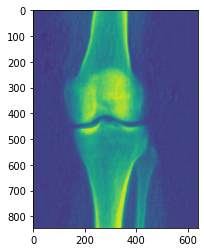

In [124]:
show(atlas[0, 0])


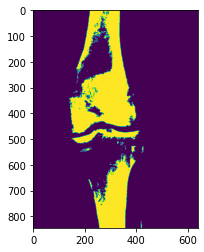

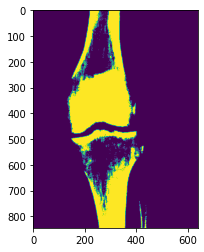

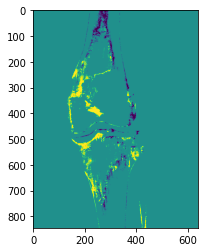

In [135]:
show(image_A[0, 0] > .5)
show(netGrad.warped_image_A[0, 0]> .5)
show((netGrad.warped_image_A[0, 0] > .5)* 1. - (image_A[0, 0] > .5) * 1.)

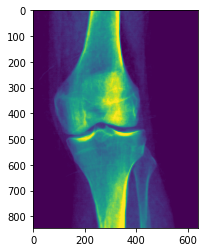

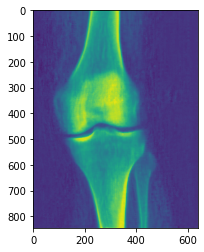

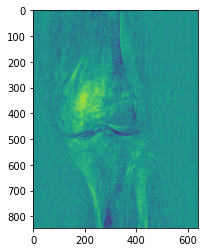

In [136]:
show(image_A[0, 0])
show(netGrad.warped_image_A[0, 0])
show((netGrad.warped_image_A[0, 0]) - (image_A[0, 0]))